# How to build a machine learning boilerplate

## Prologue

**Context**: [【Machine Learning】 10 minutes to learn what I know about machine learning in quantitative trading](https://mikelhsia.github.io/2021/04/22/2021-04-22-machine-learning-intro/)

To follow up on what we have learned in the last post, here we're going to quickly demonstrate how to build your own machine learning boilerplate. We're going to cover the steps that we introduced in the post:
1. Data curating
2. Feature discover/analyze
3. Train the model
4. Predict the expected variable
5. Form the strategy and run backtest

We're building this boilerplate on the [**JoinQuant**](https://www.joinquant.com/) platform so that we can easily access the data and factors without building them ourselves.

## 0. Import the libraries we need
There are several libraries that we need to kick off this project:

In [1]:
# The fundamental libraries that we need
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm_notebook

# The JointQuant data and factor libraries (https://www.joinquant.com/)
from jqdata import *
from jqfactor import *
from jqlib.technical_analysis import *
import pickle

# The plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

In [2]:
# Import the skelarn libraries for machine learning models
from sklearn import svm
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import decomposition

In [3]:
# Preliminary setup
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

warnings.filterwarnings('ignore')
mpl.rcParams["font.family"] = "SimHei"
mpl.rcParams["axes.unicode_minus"] = False
plt.style.use('ggplot')

## 1. Data curating
In this section, we're going to curate the data and fetch the factor data to stitch them together into a complete sheet. Having this sheet would get us ready to feed it into the model for training and predicting.

### 1.1 Set up the project scope
We're using data from `2015-01-01` to `2021-03-31` and using Zhongzheng 500 index `ZZ500` from Shanghai A security market as our portfolio benchmark.

In [4]:
# Data sampling
START_DATE = '2015-01-01'
END_DATE = '2021-03-31'

# Our benchmark would be ZZ500
INDEX = '399905.XSHE'

#### 1.1.1 Fundamental financial data
We have selected the major fundamental financial data to construct our factors. See [here](https://www.joinquant.com/help/api/help#name:Stock) to understand how to use the built-in factor set from JoinQuant.

In [5]:
q = query(valuation.code, 
      valuation.market_cap,
      valuation.circulating_market_cap,
      valuation.pe_ratio,
      valuation.pb_ratio,
      valuation.pcf_ratio, # Price to cash flow ratio
      valuation.ps_ratio, # Price to sales ratio
      balance.total_assets,
      balance.total_liability,
      balance.fixed_assets,  
      balance.total_non_current_liability,
      income.operating_profit,
      income.total_profit,
      indicator.net_profit_to_total_revenue,
      indicator.inc_revenue_year_on_year,
      indicator.inc_net_profit_year_on_year,
      indicator.roe,
      indicator.roa,
      indicator.gross_profit_margin
    )

#### 1.1.2 Get other technical factors
This step is where we acquire the other factors such as momentum factors and value factors so that we can add them to our model. See [here](https://www.joinquant.com/help/api/help#name:factor_values) for more information.

In [6]:
jqfactor_list = [
    'current_ratio',
    'net_profit_to_total_operate_revenue_ttm',
    'gross_income_ratio',
    'roe_ttm',
    'roa_ttm',
    'total_asset_turnover_rate',
    'net_operating_cash_flow_coverage',
    'net_operate_cash_flow_ttm',
    'net_profit_ttm',
    'cash_to_current_liability',
    'operating_revenue_growth_rate',
    'non_recurring_gain_loss',
    'operating_revenue_ttm',
    'net_profit_growth_rate',
    'AR',
    'ARBR',
    'ATR6',
    'ATR14',
    'CCI10',
    'VOL5',
    'VOL60',
    'ROC6',
    'ROC12',
    'WVAD',
    'Skewness20',
    'Skewness60'
]

### 1.2 Getting our trading calendar
A trading calendar is a list of days that we will revisit our portfolio and add new stocks or remove stocks. We usually use 1. **daily**, 2. **weekly**, 3. **monthly** as our frequency to construct our trading calendar.

Here we use **monthly** to review our strategy and adjust our portfolio.

In [7]:
def get_trade_days_monthly(start,end):
    '''
    Getting the trade day at the end of each month
    '''
    index = get_trade_days(start_date=start, end_date=end)
    df = pd.DataFrame(index, index=index)
    df.index = pd.to_datetime(df.index)
    
    return list(df.resample('m', how='last').iloc[:,0])

### 1.3 Filter stocks that don't fit our training model from the pool
1. Remove the stocks that are listed within three months
2. Remove the [ST stocks](https://www.baidu.com/link?url=LQLqozFktKIJ6Of9Gop1QaxMt-u9QURcBNwAwPtVXK-2_M7SkPzVpmCXMlEePB8MK_c8gZK53aia2wW-TtGvKRTyXTrtsWh4ajjRBCh7yla&wd=&eqid=a89bb1e800075dab0000000460990c3e)
3. Remove the stocks that are suspended in each period

In [8]:
def remove_new(stocks,beginDate,n):
    stocklist=[]
    if isinstance(beginDate,str):
        beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date=get_security_info(stock).start_date
        if start_date<(beginDate-datetime.timedelta(days=n)):
            stocklist.append(stock)
    return stocklist

In [9]:
def remove_st(stocks,beginDate):
    is_st = get_extras('is_st',stocks,end_date=beginDate,count=1)
    return [stock for stock in stocks if not is_st[stock][0]]

In [10]:
def remove_paused(stocks,beginDate):
    is_paused = get_price(stocks,end_date=beginDate, count=1,fields='paused',panel=False)
    return list(is_paused[is_paused['paused']!=1]['code'])

In [11]:
def get_stocks_filtered(beginDate,n,indexID=INDEX):
    '''
    :param tradedate: trading day
    :param indexID: Default to '399905.XSHE'
    :param n : n days that we consider the stocks are new
    :return:
    '''
    # 获取当天指数成份股列表
    stocklist = get_index_stocks(indexID, date=beginDate)
    stocklist = remove_new(stocklist,beginDate,n)
    stocklist = remove_st(stocklist,beginDate)
    stocklist = remove_paused(stocklist,beginDate)
    return stocklist

### 1.4 Getting factor data

In [12]:
def get_df_jqfactor(stocklist, factor_list, date):
    '''
    stocklist：list, list of stock names
    factor_list:list, list of factor names
    date:
    output: dataframe, stock code in index, factor name in column
    '''

    factor_data = get_factor_values(
        securities=stocklist,
        factors=factor_list,
        count=1,
        end_date=date
    )
    
    df_jqfactor=pd.DataFrame(index=stocklist)
    
    for factor in factor_data.keys():
        df_jqfactor[factor]=factor_data[factor].iloc[0,:]
    
    return df_jqfactor

In [13]:
def get_newfactors_df(stocklist,df,date):
    """
    stocklist: list of stocks
    df : dataframe of the original data
    date : trading date
    return : dataframe of our processed data    
    """
    df['net_assets']=df['total_assets']-df['total_liability']
    df_new = pd.DataFrame(index=stocklist)

    df_new['EP'] = df['pe_ratio'].apply(lambda x: 1/x)
    df_new['BP'] = df['pb_ratio'].apply(lambda x: 1/x)
    df_new['SP'] = df['ps_ratio'].apply(lambda x: 1/x)
    df_new['CFP'] = df['pcf_ratio'].apply(lambda x: 1/x)
    df_new['financial_leverage']=df['total_assets']/df['net_assets']
    df_new['debtequityratio']=df['total_non_current_liability']/df['net_assets']
    df_new['cashratio']=df['cash_to_current_liability']
    df_new['currentratio']=df['current_ratio']
    
    df_new['NI'] = df['net_profit_to_total_operate_revenue_ttm']
    df_new['GPM'] = df['gross_income_ratio']
    df_new['ROE'] = df['roe_ttm']
    df_new['ROA'] = df['roa_ttm']
    df_new['asset_turnover'] = df['total_asset_turnover_rate']
    df_new['net_operating_cash_flow'] = df['net_operating_cash_flow_coverage']
    
    df_new['Sales_G_q'] = df['operating_revenue_growth_rate']
    df_new['Profit_G_q'] = df['net_profit_growth_rate']
    
    df_new['RSI']=pd.Series(RSI(stocklist, date, N1=20))  
    df_new['BIAS']=pd.Series(BIAS(stocklist,date, N1=20)[0])
    df_new['PSY']=pd.Series(PSY(stocklist, date, timeperiod=20))
    
    dif,dea,macd=MACD(stocklist, date, SHORT = 10, LONG = 30, MID = 15)
    df_new['DIF']=pd.Series(dif)
    df_new['DEA']=pd.Series(dea)
    df_new['MACD']=pd.Series(macd)    
    df_new['AR'] = df['AR']    
    df_new['ARBR'] = df['ARBR']
    df_new['ATR6'] = df['ATR6']
    df_new['ATR14'] = df['ATR14']
    df_new['ARBR'] = df['ARBR']
    df_new['CCI10'] = df['CCI10']

    df_new['VOL5'] = df['VOL5']
    df_new['VOL60'] = df['VOL60']
    df_new['ROC6'] = df['ROC6']
    df_new['ROC12'] = df['ROC12']
    
    df_new['WVAD'] = df['WVAD']

    df_new['Skewness20'] = df['Skewness20']
    df_new['Skewness60'] = df['Skewness60']
    
    df_new['date'] = date

    return df_new

In [14]:
def get_all_factors_dict(trade_days,q):
    original_factor_df = None
    for date in tqdm_notebook(trade_days):
        stocklist = get_stocks_filtered(date,90,indexID=INDEX)
        
        # Getting financial data
        q_new = q.filter(valuation.code.in_(stocklist))
        q_factor = get_fundamentals(q_new,date=date)
        q_factor.set_index('code',inplace=True)

        # Getting factor data
        df_jqfactor = get_df_jqfactor(
            stocklist, 
            jqfactor_list, 
            date
        )
        
        # concat two data into one sheet
        if original_factor_df is None:
            original_factor_df = get_newfactors_df(
                stocklist,
                pd.concat([q_factor,df_jqfactor],axis=1),
                date
            )
        else:
            original_factor_df = pd.concat([original_factor_df, get_newfactors_df(
            stocklist,
            pd.concat([q_factor,df_jqfactor],axis=1),
            date
        )], axis=0)
    return original_factor_df

In [14]:
# Trading calendar
trade_days_all = get_trade_days_monthly(START_DATE,END_DATE)

In [15]:
%%time
original_factor_dict = get_all_factors_dict(trade_days_all, q)

Here we preserve the data so that we don't have to run this step again if there's another model that we would like to train.

In [16]:
content = pickle.dumps(original_factor_dict) 
write_file('original_factor_dict.pkl', content, append=False)

---

## 2. Training and predicting
Now, since we have all the data and factors prepared, we're ready to train our model, and then we will use this model to predict the future return.

We're going to do a little bit differently here as we spoke in [【Machine Learning】 10 minutes to learn what I know about machine learning in quantitative trading](https://mikelhsia.github.io/2021/04/22/2021-04-22-machine-learning-intro/). Instead of splitting data into training and testing data and train then test, we are going to train the model every time when we need to test one single period. See the below image for illustration.

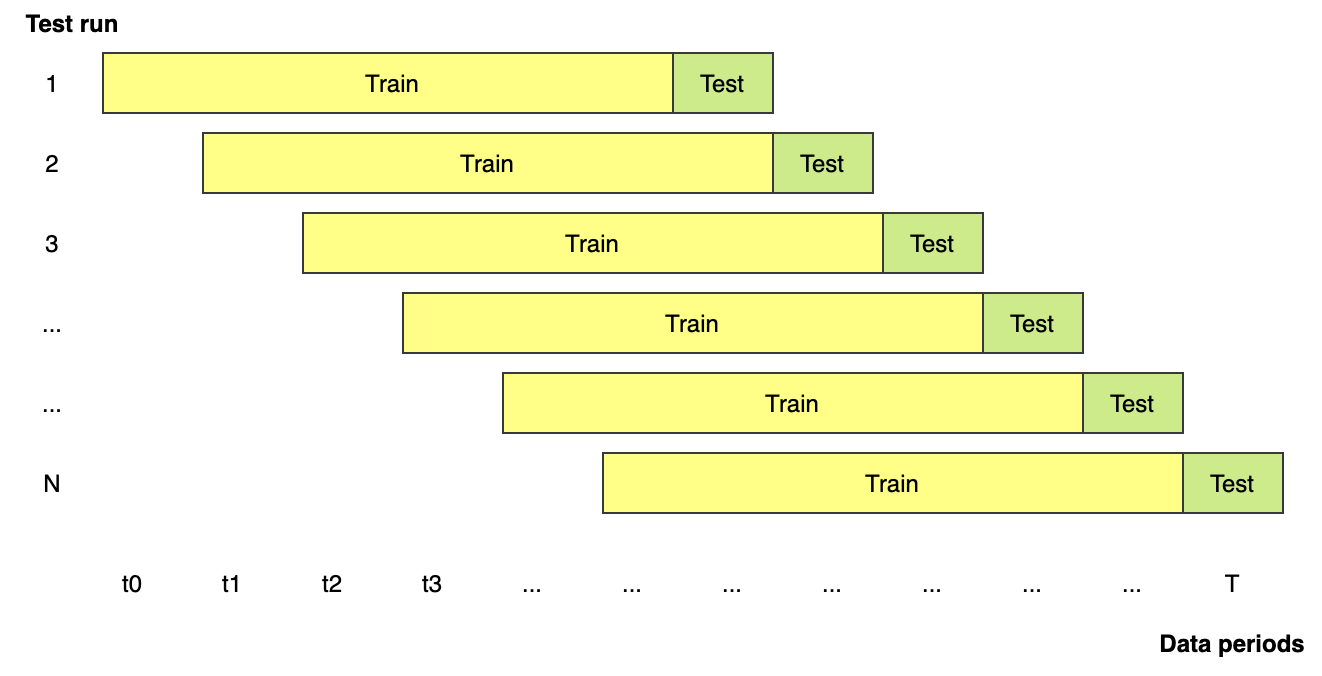

If we're doing this in the old way, we can only test every period with the same trained model without taking into account the latest public data. On the contrary, we can test each period with the updated trained model by doing training our model this way.

### 2.1 Loading data
To begin with, we load our data and calculate the `rtn` column as our independent variable. 

In [15]:
with open('original_factor_dict.pkl','rb') as pf:
    original_factor_df = pickle.load(pf)

data = (original_factor_df.reset_index()
        .sort_values(['date', 'index'])
        .rename(columns={'index':'ticker'})
        .set_index(['date', 'ticker']))

In [16]:
data['close'] = np.nan
for d in tqdm_notebook(data.index.levels[0].tolist()):
    z = get_price(
        data.loc[d].index.tolist(), 
        end_date=d, 
        count=1,
        fields='close',
        panel=False
    )
    data.loc[d, 'close'] = z.rename(columns={'code':'ticker'}).set_index('ticker').close.values

# display(data)

In [17]:
data['rtn'] = data['close'].groupby('ticker').apply(lambda x:x.pct_change())
data['rtn'] = data['rtn'].shift(-1)
data.drop(['close'], axis=1, inplace=True)
data.dropna(inplace=True)

factor_names = data.columns.tolist()
factor_names.remove('rtn')

content = pickle.dumps(data) 
write_file('test.pkl', content, append=False)

9284463

### 2.2 Model parameters setup

- **method = 'SVM'**
  - Specify we're using SVM (Support Vector Machine) as our logistic regression model
- **in_out_sample_split = 0.5**
  - This ratio indicates that we're going to use 50% of the data in training and the rest of the data in testing
- **percent_select = [0.3, 0.3]**
  - Instead of train the model with numbers on a linear scale, we're going to take the stocks whose return is in the top 30% and the bottom 30%. For the stocks whose return is in our top 30%, we will mark it as `1`, and vice-versa. 
- **svm_kernel = 'rbf'**
  -  Gaussian kernel. We're not going to explain further here.
- **svm_c = 0.01**
  - svm_c is the penalty for stability. We're not going to explain further here.
- **lookback_periods = 24**
  - For each testing period, we're going to take the previous 24 months as our training data to train our model.

In [18]:
method = 'SVM'

# Ratio of spliting data into the training data and the testing data
in_out_sample_split = 0.5

# 30% positive samples, 30% negative samples
percent_select = [0.3, 0.3]

# SVM model kernel, can switch to logistic later
svm_kernel = 'rbf' # 高斯核

# SVM parameter
svm_c = 0.01

# Lookback periods of training set when testing specific period
lookback_periods = 24

In [19]:
with open('test.pkl','rb') as pf:
    data = pickle.load(pf)

Using `in_out_sample_split` and our index in the DataFrame to find out where we should split our training and testing data.

In [20]:
split_date_index = round(len(data.index.levels[0])*in_out_sample_split)

### 2.3 Start training and testing
Here's a short description of what we're doing in this cell
1. We loop through each date in testing data and extract our training data
2. Process our data
  1. Standardize our data and run PCA ([*Principal Component Analysis*](https://www.baidu.com/link?url=LHXtadnEsozBvdFYRKcnvWqYpGW8QlILISZCs0uOy1CTumel2zzGYl0K5r58VXFN&wd=&eqid=8a2505d4000541b8000000046099fccf)) to transform our data.
  2. Label our data with `1` if the stock return is in the top 30%, and `0` if is in the bottom 30%.
4. Feed this training data into the model
5. Use the trained model and the data on the testing date to produce the testing result.

In [21]:
%%time

y_pred_test = None
y_score_test = None

tb = pd.DataFrame(columns=['Target', 
    'Training periods', 
    'Training Accuracy', 
    'Training AUC',
    'Testing Accuracy',
    'Testing AUC'])

for test_data_index in tqdm_notebook(range(split_date_index, len(data.index.levels[0]))):
    
    # Split training data
    training_start_idx = test_data_index - lookback_periods
    training_end_idx = test_data_index - 1
    
    training_data = data.loc[data.index.levels[0][test_data_index-lookback_periods]:data.index.levels[0][test_data_index-1], :]
        
    # Labeling
    training_data = training_data.sort_values(by='rtn', ascending=False)

    training_data['rtn_bin'] = np.nan
    rtn_bin_index = training_data.columns.tolist().index('rtn_bin')

    n_stock_select = np.around(np.multiply(percent_select, training_data.shape[0])).astype(int)
    training_data.iloc[:n_stock_select[0], rtn_bin_index] = 1
    training_data.iloc[-n_stock_select[1]:, rtn_bin_index] = 0

    training_data.dropna(axis=0, inplace=True)
    training_data.sort_index(inplace=True)

    training_data_x = training_data[factor_names]
    training_data_y = training_data['rtn_bin']
    # Optional
    # training_data_y = training_data['rtn']

    # Scaling data
    scaler = preprocessing.StandardScaler().fit(training_data_x)
    training_data_x = scaler.transform(training_data_x)
    
    # PCA
    pca = decomposition.PCA(n_components=0.95)
    pca.fit(training_data_x)
    training_data_x = pca.transform(training_data_x)

    # Training
    if method == 'SVM':
        model = svm.SVC(kernel=svm_kernel, C=svm_c)

        model.fit(training_data_x, training_data_y)
        y_pred_train = model.predict(training_data_x)
        y_score_train = model.decision_function(training_data_x)
    else:
        raise Exception('Machine learning method not specified')

    # Testing and evaluation
    y_true_curr = data.loc[data.index.levels[0][test_data_index], 'rtn']
    X_curr = data.loc[data.index.levels[0][test_data_index], factor_names]
    X_curr_month = scaler.transform(X_curr)
    X_curr_month = pca.transform(X_curr_month)

    if method == 'SVM':
        y_pred_curr_mon = model.predict(X_curr_month)
        y_score_curr_mon = model.decision_function(X_curr_month)
        y_pred_curr = pd.DataFrame([y_pred_curr_mon], index=[data.index.levels[0][test_data_index]], columns=X_curr.index.get_level_values(0).tolist())
        y_score_curr = pd.DataFrame([y_score_curr_mon], index=[data.index.levels[0][test_data_index]], columns=X_curr.index.get_level_values(0).tolist())
    else:
        raise Exception('Machine learning method not specified')
        
            
    if y_pred_test is None and y_score_test is None:
        y_pred_test = y_pred_curr
        y_score_test = y_score_curr
    else:
        y_pred_test = y_pred_test.append(y_pred_curr)
        y_score_test = y_score_test.append(y_score_curr)
    
    # Evaluation
    y_true_curr = y_true_curr.to_frame(name="rtn")
    y_true_curr['rtn_bin'] = np.nan
    y_true_curr = y_true_curr.sort_values(by='rtn', ascending=False)

    n_stock_select = np.around(np.multiply(percent_select, y_true_curr.shape[0])).astype(int)
    
    y_true_curr.loc[:n_stock_select[0], "rtn_bin"] = 1
    y_true_curr.loc[-n_stock_select[1]:, "rtn_bin"] = 0

    y_true_curr.dropna(axis=0, inplace=True)
    y_true_curr.sort_index(inplace=True)
    
    tb = tb.append(
        {
            'Target':f'{data.index.levels[0][test_data_index].strftime("%Y-%m-%d")}', 
            'Training periods':f'{data.index.levels[0][test_data_index-lookback_periods].strftime("%Y-%m-%d")} - {data.index.levels[0][test_data_index-1].strftime("%Y-%m-%d")}', 
            'Training Accuracy':round(metrics.accuracy_score(training_data_y, y_pred_train), 3), 
            'Training AUC':round(metrics.roc_auc_score(training_data_y, y_score_train), 3),
            'Testing Accuracy':round(metrics.accuracy_score(
                y_true_curr['rtn_bin'], 
                y_pred_curr.loc[:, y_true_curr.index.tolist()].T
            ), 3),
            'Testing AUC':round(metrics.roc_auc_score(
                y_true_curr['rtn_bin'], 
                y_score_curr.loc[:, y_true_curr.index.tolist()].T
            ), 3)
        }, ignore_index=True
    )
    
display(tb)

,Target,Training periods,Training Accuracy,Training AUC,Testing Accuracy,Testing AUC
0,2018-03-30,2016-03-31 - 2018-02-28,0.637,0.679,0.545,0.585
1,2018-04-27,2016-04-29 - 2018-03-30,0.612,0.652,0.504,0.504
2,2018-05-31,2016-05-31 - 2018-04-27,0.619,0.657,0.488,0.512
3,2018-06-29,2016-06-30 - 2018-05-31,0.617,0.653,0.496,0.499
4,2018-07-31,2016-07-29 - 2018-06-29,0.633,0.674,0.527,0.549
5,2018-08-31,2016-08-31 - 2018-07-31,0.631,0.675,0.511,0.497
6,2018-09-28,2016-09-30 - 2018-08-31,0.627,0.675,0.500,0.486
7,2018-10-31,2016-10-31 - 2018-09-28,0.627,0.675,0.468,0.495
8,2018-11-30,2016-11-30 - 2018-10-31,0.629,0.679,0.490,0.500
9,2018-12-28,2016-12-30 - 2018-11-30,0.623,0.674,0.496,0.535


CPU times: user 5min 51s, sys: 3.74 s, total: 5min 55s
Wall time: 6min 6s


Let's take a look at the differences between training results and testing results. We're using **accuracy** and **AUC** to quickly evaluate our model.

**Accuracy** is calculated by comparing the values that we predicted with the actual results. The accuracy ratio equals the number of correctly predicted cases divided by the number of total cases.

$$accuracy = \frac{N_{correct}}{N_{total}}$$

And **AUC** is another method to calculate the accuracy of the model. Its biggest difference from the accuracy above is that AUC includes the concept of **Confusion Matrix**. We simply need to know that the higher AUC score indicates that the model is much more accurate in predicting the future return.



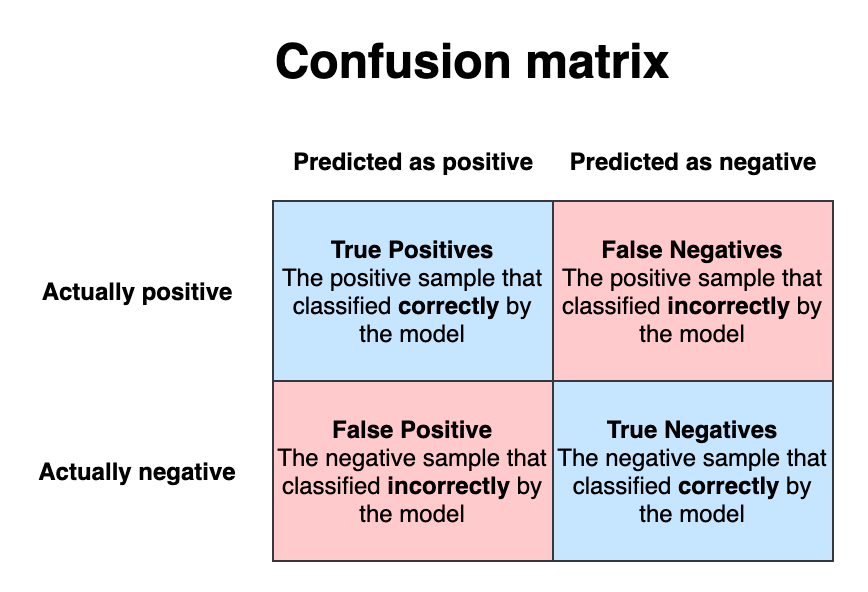



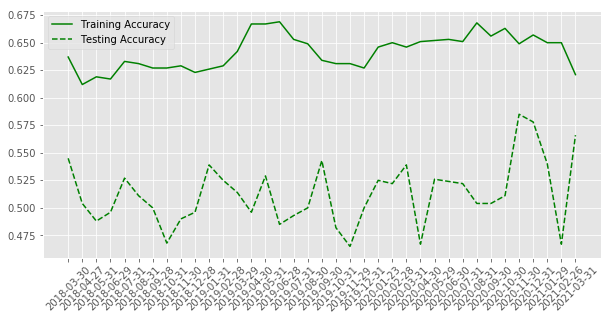

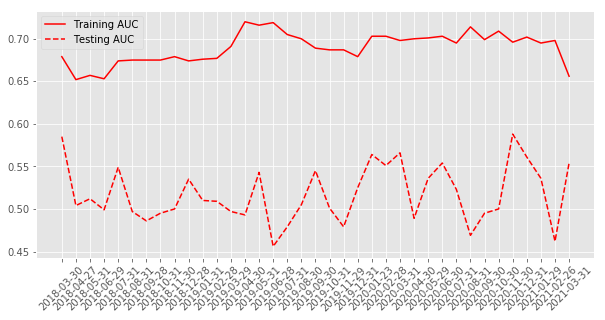

In [23]:
fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 1)

l1, = ax1.plot(tb['Target'], tb['Training Accuracy'], 'g-')
l2, = ax2.plot(tb['Target'], tb['Testing Accuracy'], 'g--')
plt.legend([l1, l2], ['Training Accuracy', 'Testing Accuracy'], loc = 'best')
plt.xticks(rotation=45)
plt.show()

fig = plt.figure(2, figsize=(10, 10))
ax3 = plt.subplot(2, 1, 2)
ax4 = plt.subplot(2, 1, 2)
l12, = ax3.plot(tb['Target'], tb['Training AUC'], 'r-')
l22, = ax4.plot(tb['Target'], tb['Testing AUC'], 'r--')
plt.legend([l12, l22], ['Training AUC', 'Testing AUC'], loc = 'best')
plt.xticks(rotation=45)
plt.show()

So we can see that the testing accuracy and AUC are lower than the training accuracy and AUC. However, the testing accuracy and AUC are above 0.5 most of the time. This means that our model still has a certain ability to predict the future return.

## 3. Building the strategy
### 3.1 Rules of how to form our strategy
Our strategy would be fairly simple: 
1. we pick 100 stocks that are most likely to generate a positive return, 
2. we evenly distribute our capital to each stock. 

In [37]:
n = 100

test_data = data.loc[data.index.levels[0][split_date_index + 1]:, :]
test_data_indexes = test_data.index.get_level_values(0)[~test_data[factor_names].index.get_level_values(0).duplicated(keep='first')]

final_df = pd.DataFrame(columns=['port_rtn', 'benchmark_rtn', 'acc_value', 'benchmark_acc_value'])

for m in test_data_indexes:
    y_true_curr = test_data.loc[m, 'rtn']
    y_pred_curr = y_pred_test.loc[m]
    y_score_curr = y_score_test.loc[m]
    
    y_score_curr = y_score_curr.sort_values(ascending=False)
    index_select = y_score_curr[:n].index
    final_df.loc[m, 'port_rtn'] = np.mean(y_true_curr[index_select])
    final_df.loc[m, 'benchmark_rtn'] = np.mean(y_true_curr)

final_df['acc_value'] = (final_df['port_rtn'] + 1).cumprod()
final_df['benchmark_acc_value'] = (final_df['benchmark_rtn'] + 1).cumprod()
display(final_df)

,port_rtn,benchmark_rtn,acc_value,benchmark_acc_value
2018-04-27,-0.042048,-0.0468408,0.957952,0.953159
2018-05-31,-0.0163055,-0.015518,0.942332,0.938368
2018-06-29,-0.110709,-0.109978,0.838008,0.835169
2018-07-31,0.00460367,0.000620309,0.841866,0.835687
2018-08-31,-0.0729608,-0.0806602,0.780442,0.76828
2018-09-28,-0.0100338,-0.000799544,0.772612,0.767666
2018-10-31,-0.118941,-0.105487,0.680716,0.686687
2018-11-30,0.0378448,0.0365691,0.706478,0.711799
2018-12-28,-0.0566418,-0.0559237,0.666462,0.671992
2019-01-31,-0.0064064,-0.00537477,0.662192,0.66838


### 3.2 Evaluate the strategy
Evaluating the strategy would be the last step of this tutorial, and also would be the last step for you to move your investment idea to the production level. We can compare our portfolio return with the return of the benchmark, which is the Zongzheng 500 index. Secondly, we can also calculate with standard metrics that help you to understand the nature of your portfolio better.

#### 3.2.1 Comparision with benchmark

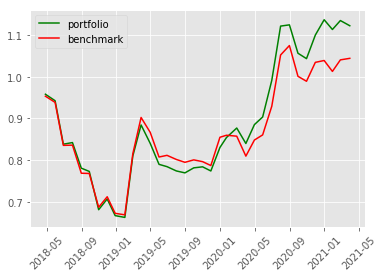

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(255)
ax1 = plt.subplot(1, 1, 1)
ax2 = plt.subplot(1, 1, 1)

l1, = ax1.plot(test_data_indexes, final_df['acc_value'], 'g-')
l2, = ax2.plot(test_data_indexes, final_df['benchmark_acc_value'], 'r-')
plt.legend([l1, l2], ['portfolio', 'benchmark'], loc = 'best')
plt.xticks(rotation=45)
plt.show()

The plot above shows that rather than outperforming the index, our portfolio actually closely tracks the movement of the index. The portfolio would only be able to outperform the `ZZ500` index starting `2020-04`.

#### 3.2.2 Portfolio metrics

We are using the following metrics to evaluate our portfolio:
- **Annualized return**: Annualized portfolio return
- **Annualized volatility**: This metric specifies how volatile your portfolio return is. If the volatility of your portfolio is high, you could make 10% of your capital overnight, and lose them all the other day.
- **Annualized Sharpe Ratio**: The higher this number is, the higher chance your portfolio would be profitable with less risk involved.
$$Sharpe\ Ratio = \frac{Excess\ return\ of\ your\ portfolio}{Standard\ deviation\ of\ your\ portfolio\ return}$$

- **Annualized Calmar Ratio**: This is an advanced version of the Sharpe Ratio. Instead of using the standard deviation of your portfolio return, we use the maximum drawdown in the denominator. This would help us understand better what our expected return would be compared to the maximum loss.

$$Calmar\ Ratio = \frac{Excess\ return\ of\ your\ portfolio}{Maximum\ drawdown}$$

In [39]:
ann_return = np.mean(final_df['port_rtn']) * 12
ann_vol = np.std(final_df['port_rtn']) * np.sqrt(12)
info_ratio = ann_return / ann_vol
ann_sharpe_ratio = (np.mean(final_df['port_rtn'] - final_df['benchmark_rtn'])/np.std(final_df['port_rtn'])) * np.sqrt(12)

final_df['max_total'] = final_df['acc_value'].expanding().max()
final_df['per_total'] = final_df['acc_value']/final_df['max_total']
min_point_total = final_df.sort_values(by=['per_total']).iloc[[0], final_df.columns.get_loc('per_total')]
max_point_total = final_df[final_df.index <= min_point_total.index[0]].sort_values(by=['acc_value'],ascending=False).iloc[[0],final_df.columns.get_loc('acc_value')]

calmar_ratio = (np.mean(final_df['port_rtn'] - final_df['benchmark_rtn'])/(1 - min_point_total.values)) * np.sqrt(12)

print(f'Annualized return = {ann_return:.2f}')
print(f'Annualized volatility = {ann_vol:.2f}')
# print(f'Annualized information ratio = {info_ratio:.2f}')
print(f'Annualized Sharpe Ratio = {ann_sharpe_ratio:.3f}')
# print("Max Dropdown: %5.2f%% since %s to %s"%((1 - min_point_total.values),max_point_total.index[0],min_point_total.index[0]))
print(f'Annualized Calmar Ratio = {calmar_ratio[0]:.3f}')

Annualized return = 0.06
Annualized volatility = 0.22
Annualized information ratio = 0.28
Annualized Sharpe Ratio = 0.109
Annualized Calmar Ratio = 0.023


#### 3.2.3 Further adjustment
As individual traders, we probably won't be able to invest our capital into 100 stocks. So let's see how does our portfolio work if we invest only 20 stocks.

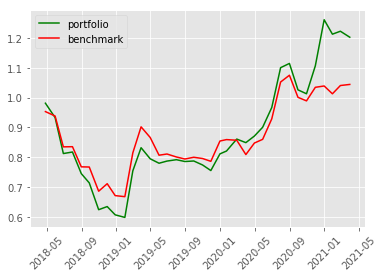

- Annualized return = 0.09
- Annualized volatility = 0.26
- Annualized Sharpe Ratio = 0.213
- Annualized Calmar Ratio = 0.041

Apparently, our portfolio still trying to follow the index movement. However, our tracking error would seem a bit higher compared to the tracking error of our previous 100-stock portfolio. We do have a higher annualized return, but in the meantime incurring higher volatility as well.


This result exactly proves the theory that the risk can be diversified if you invest in enough stocks. Then we just need to understand the level of risk aversion of ourselves and invest our capital according to our strategy.

---